<a href="https://colab.research.google.com/github/Marwa-199/Bikeshare_Predict/blob/main/Predict_BikeShare_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
![kaggle1.png](attachment:kaggle1.png)
![kaggle2.png](attachment:kaggle2.png)
2. Scroll down to API and click Create New API Token.
![kaggle3.png](attachment:kaggle3.png)
![kaggle4.png](attachment:kaggle4.png)
3. Open up `kaggle.json` and use the username and key.
![kaggle5.png](attachment:kaggle5.png)

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [ ]:
!pip install --upgrade mxnet
!pip install autogluon

In [ ]:
import autogluon as ag
import pandas as pd
import numpy as np
import os,urllib
%matplotlib inline

In [ ]:
from autogluon.tabular import TabularPredictor 
from datetime import datetime

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "marwaal"
kaggle_key = "f9062ab3925108f9af4beb3067bf68e1"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
![kaggle6.png](attachment:kaggle6.png)

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
#!kaggle competitions download -c bike-sharing-demand.zip
# If you already downloaded it you can use the -o command to overwrite the file
#!unzip -o bike-sharing-demand.zip

In [ ]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv',parse_dates=['datetime'])
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [ ]:
# check null values 
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
# check duplicates 
train.duplicated().sum()

0

In [ ]:
# check the data types of datetime
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [ ]:
# Simple output of the train dataset to view some of the min/max/variation of the dataset features 
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [ ]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [ ]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [ ]:
# Same thing as train and test dataset
submission =  pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
features = ["datetime","season","holiday","workingday","weather","temp","atemp","humidity","windspeed","count"]

predictor = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error"
).fit(
    train[features],
    time_limit= 600 ,
    presets = "best_quality"
    )


Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20220928_163218/"
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20220928_163218/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.14
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    10886
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 9
INFO:autogluon.tabular.learner.default_learner:Label Column: count
INFO:autogluon.tabular.l

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.703077      13.375396  469.191475                0.000817           0.367942            3       True         17
1   RandomForestMSE_BAG_L2  -53.437033      12.103134  407.894128                0.605558          25.858896            2       True         13
2     ExtraTreesMSE_BAG_L2  -53.673605      12.087683  389.659133                0.590107           7.623900            2       True         15
3          LightGBM_BAG_L2  -55.221017      11.688646  400.365691                0.191070          18.330459            2       True         12
4          CatBoost_BAG_L2  -55.582476      11.578871  445.347350                0.081295          63.312118            2       True         14
5   NeuralNetFastAI_BAG_L2  -58.947114      11.987845  417.010277         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.546199084

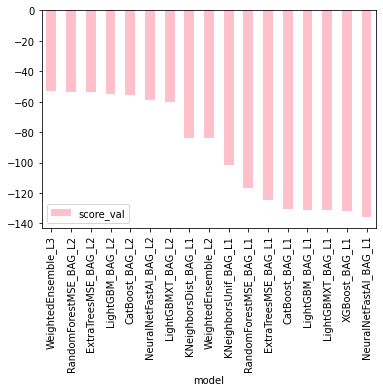

In [ ]:
predictor.leaderboard(silent=True).plot(kind= "bar", x = "model" , y = "score_val" ,color ='pink')

### Create predictions from test dataset

In [ ]:
predictions = predictor.predict(test)
predictions.head()

0    22.347845
1    41.804237
2    45.411419
3    48.049984
4    51.339310
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [ ]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      101.960243
std        90.181030
min         2.007205
25%        23.301001
50%        66.548256
75%       170.738281
max       360.897400
Name: count, dtype: float64

In [ ]:
# Set them to zero
predictions = predictions.clip(lower=0)


### Set predictions to submission dataframe, save, and submit

In [ ]:
submission["count"] = predictions
submission["count"] = submission["count"].apply(lambda x : round(x))

submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100% 148k/148k [00:03<00:00, 44.9kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-09-28 16:48:42  first raw submission  complete  1.77954      1.77954       





#### Initial score of 1.77954      

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

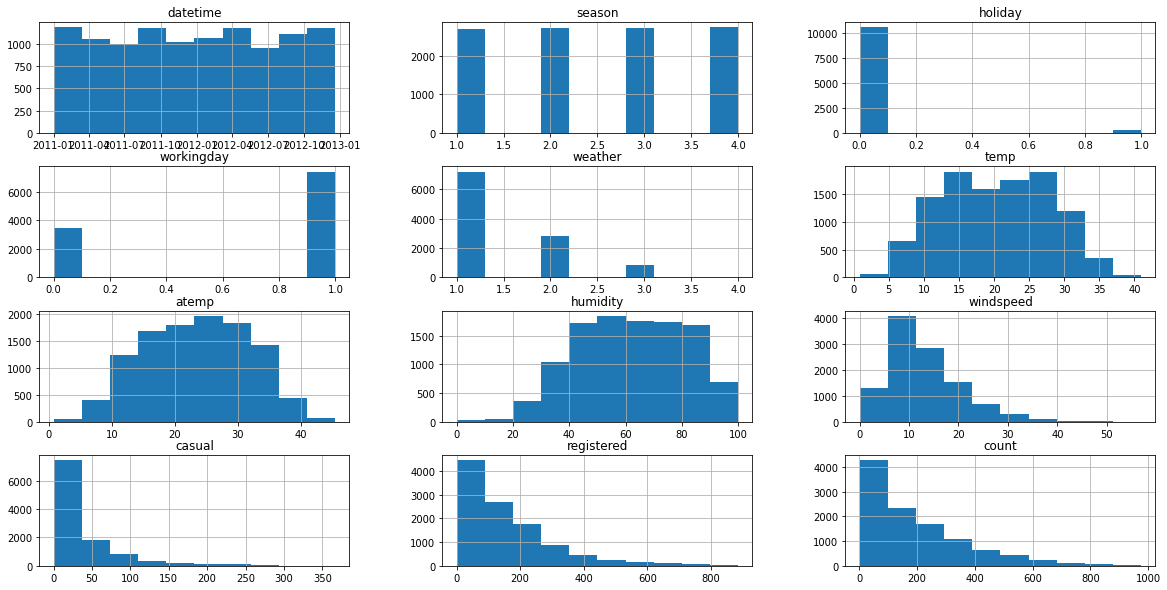

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20,10));


In [ ]:
# create new features
train['year']  = pd.to_datetime ( train.loc[:, 'datetime'] ).dt.year
train['month'] = pd.to_datetime ( train.loc[:, 'datetime'] ).dt.month
train['day']   = pd.to_datetime ( train.loc[:, 'datetime'] ).dt.day
train['hour']  = pd.to_datetime ( train.loc[:, 'datetime'] ).dt.hour

test['year']  = pd.to_datetime ( test.loc[:, 'datetime'] ).dt.year
test['month'] = pd.to_datetime ( test.loc[:, 'datetime'] ).dt.month
test['day']   = pd.to_datetime ( test.loc[:, 'datetime'] ).dt.day
test['hour']  = pd.to_datetime ( test.loc[:, 'datetime'] ).dt.hour


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
train["season"]    = train["season"].astype("category")
train["holiday"]   = train["holiday"].astype("category")
train["workingday"]= train["workingday"].astype("category")
train["weather"]   = train["weather"].astype("category")
train["year"]      = train["year"].astype("category")
train["month"]     = train["month"].astype("category")
train["day"]       = train["day"].astype("category")
train["hour"]      = train["hour"].astype("category") 


test["season"]    = test["season"].astype("category")
test["holiday"]   = test["holiday"].astype("category")
test["workingday"]= test["workingday"].astype("category")
test["weather"]   = test["weather"].astype("category")
test["year"]      = test["year"].astype("category")
test["month"]     = test["month"].astype("category")
test["day"]       = test["day"].astype("category")
test["hour"]      = test["hour"].astype("category")

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  category      
 13  month       10886 non-null  category      
 14  day         10886 non-null  category      
 15  hour        10886 non-null  category      
dtypes: category(8), dateti

In [ ]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


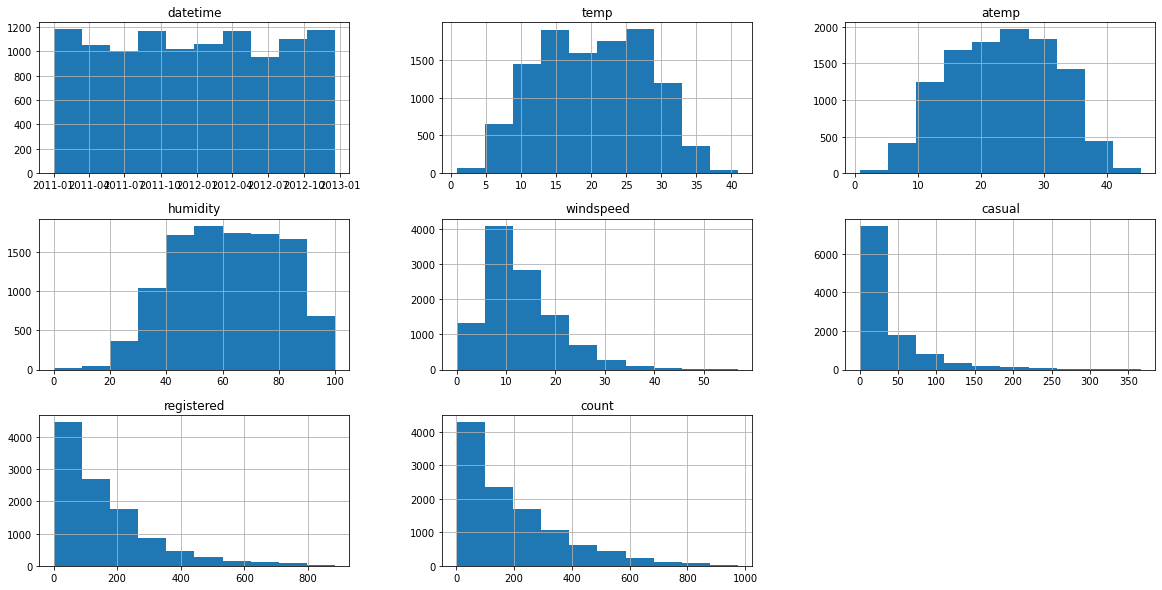

In [ ]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20,10));

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour'],
      dtype='object')

In [ ]:
new_features = ["season","holiday","workingday","weather","temp","humidity","windspeed","count","year", "month", "day", "hour"]

predictor_new_features = TabularPredictor(
    label="count",
    eval_metric="root_mean_squared_error"
).fit(
    train[new_features],
    time_limit= 600 ,
    presets = "best_quality"
    )


Level 25:autogluon.common.utils.utils:No path specified. Models will be saved in: "AutogluonModels/ag-20220928_171325/"
INFO:autogluon.tabular.predictor.predictor:Presets specified: ['best_quality']
INFO:autogluon.tabular.predictor.predictor:Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ... Time limit = 600s
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "AutogluonModels/ag-20220928_171325/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.14
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    10886
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 11
INFO:autogluon.tabular.learner.default_learner:Label Column: count
INFO:autogluon.tabular.

In [ ]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -37.035030      10.270353  543.249524                0.001150           0.429277            3       True         16
1      WeightedEnsemble_L2  -37.188850       8.534148  395.403774                0.001056           0.559861            2       True          9
2     ExtraTreesMSE_BAG_L2  -37.214363       9.567735  406.144128                0.826973          11.253965            2       True         14
3          CatBoost_BAG_L2  -37.516885       8.885684  481.032956                0.144921          86.142793            2       True         13
4          LightGBM_BAG_L2  -37.733041       8.871695  411.420313                0.130932          16.530149            2       True         11
5   RandomForestMSE_BAG_L2  -37.919016       9.359673  419.067823         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -165.14207054922935,
  'KNeighborsDist_BAG_L1': -179.4216148241622

In [ ]:
predictor_new_features.leaderboard(silent=True).plot(kind= "bar", x = "model" , y = "score_val" ,color ='pink')

AttributeError: ignored

In [ ]:
predictor_new_features = predictor_new_features.predict(test)
predictor.head()

0    10.924042
1     4.622432
2     3.674049
3     3.049295
4     2.848367
Name: count, dtype: float32

In [ ]:
predictor.describe()

count    6493.000000
mean      189.793350
std       174.846970
min         0.960622
25%        46.584290
50%       146.375671
75%       285.276520
max       898.307983
Name: count, dtype: float64

In [ ]:
# Remember to set all negative values to zero
predictor_new_features = predictor.clip(lower=0)

In [ ]:
# Same submitting predictions
submission_new_features["count"] =  predictor_new_features
submission_new_features["count"] =  submission_new_features["count"].apply(lambda x : round(x))

submission_new_features.to_csv("submission_new_features.csv", index=False)

NameError: ignored

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of 0.457

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
predictor_new_hpo = TabularPredictor(?).fit(?)

In [ ]:
predictor_new_hpo.fit_summary()

In [ ]:
# Remember to set all negative values to zero
predictor_new_hpo = predictor.clip(lower=0)

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})